In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the MPRA results
mpra_df = pd.read_csv('../data/mpra_results.csv')

print("Data loaded successfully!")
print(f"Shape: {mpra_df.shape}")
print("\nFirst few rows:")
print(mpra_df.head())
print("\nColumn names:")
print(mpra_df.columns.tolist())


Data loaded successfully!
Shape: (603, 8)

First few rows:
  cell_line  replicate  dna_count  rna_count  rna_dna_ratio      log2  \
0     HepG2          1   0.155963   0.267328       1.714048  0.777407   
1     HepG2          1   0.240014   0.796088       3.316842  1.729810   
2     HepG2          1   0.149031   0.132283       0.887623 -0.171981   
3     HepG2          1   0.244274   0.293641       1.202097  0.265553   
4     HepG2          1   0.111494   0.241111       2.162551  1.112734   

   n_obs_bc            sequence_name  
0        63   skilled_freaky_sunbear  
1        77    zippered_grownup_eyra  
2       127        flimsy_novel_lice  
3       105    binding_lucid_gemsbok  
4       125  separate_resident_pygmy  

Column names:
['cell_line', 'replicate', 'dna_count', 'rna_count', 'rna_dna_ratio', 'log2', 'n_obs_bc', 'sequence_name']


In [100]:

# Calculate mean ratio per sequence per cell line (averaging across replicates)
mean_activity = mpra_df.groupby(['sequence_name', 'cell_line'])['rna_dna_ratio'].agg(['mean', 'std', 'count']).reset_index()
mean_activity.columns = ['sequence_name', 'cell_line', 'mean_ratio', 'std_ratio', 'n_replicates']

print("\nMean activity per sequence per cell line:")
print(mean_activity.head())

# Pivot to create a matrix of sequences x cell lines
activity_matrix = mean_activity.pivot(index='sequence_name', columns='cell_line', values='mean_ratio')

print("\nActivity matrix shape:", activity_matrix.shape)
print("\nCell lines:", activity_matrix.columns.tolist())



Mean activity per sequence per cell line:
            sequence_name cell_line  mean_ratio  std_ratio  n_replicates
0  academic_lunatic_eagle     HepG2    2.292735   0.038390             3
1  academic_lunatic_eagle      K562    0.568472   0.017152             3
2  academic_lunatic_eagle     WTC11    0.475173   0.012987             3
3   acrylic_native_minnow     HepG2    0.812632   0.036368             3
4   acrylic_native_minnow      K562    0.767860   0.009345             3

Activity matrix shape: (67, 3)

Cell lines: ['HepG2', 'K562', 'WTC11']


In [101]:

# Method 1: Calculate specificity score using coefficient of variation
# Higher CV = more cell line specific
def calculate_specificity_cv(row):
    """Calculate coefficient of variation as a measure of specificity"""
    mean_val = row.mean()
    std_val = row.std()
    if mean_val > 0:
        cv = std_val / mean_val
    else:
        cv = 0
    return cv

# Method 2: Calculate fold-change specificity
# For each sequence, find max/mean ratio
def calculate_specificity_fc(row):
    """Calculate fold-change specificity (max/mean of other cell lines)"""
    max_val = row.max()
    max_cell = row.idxmax()
    other_vals = row.drop(max_cell)
    if len(other_vals) > 0 and other_vals.mean() > 0:
        fc = max_val / other_vals.mean()
    else:
        fc = 0
    return fc, max_cell, max_val

# Method 3: Calculate entropy-based specificity
def calculate_entropy_specificity(row):
    """Lower entropy = more specific. Returns 1-normalized_entropy as specificity score"""
    # Normalize to probabilities
    total = row.sum()
    if total > 0:
        probs = row / total
        # Calculate entropy
        entropy = -np.sum(probs * np.log2(probs + 1e-10))
        # Normalize by max possible entropy
        max_entropy = np.log2(len(row))
        normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
        # Return specificity (1 - normalized entropy)
        specificity = 1 - normalized_entropy
    else:
        specificity = 0
    return specificity


In [102]:

# Calculate all specificity metrics
specificity_results = pd.DataFrame(index=activity_matrix.index)

# CV-based specificity
specificity_results['cv_specificity'] = activity_matrix.apply(calculate_specificity_cv, axis=1)

# Fold-change specificity
fc_results = activity_matrix.apply(lambda row: pd.Series(calculate_specificity_fc(row)), axis=1)
specificity_results['fc_specificity'] = fc_results[0]
specificity_results['most_active_cell_line'] = fc_results[1]
specificity_results['max_activity'] = fc_results[2]

# Entropy-based specificity
specificity_results['entropy_specificity'] = activity_matrix.apply(calculate_entropy_specificity, axis=1)

# Add mean activity across all cell lines
specificity_results['mean_activity_all_cells'] = activity_matrix.mean(axis=1)




TOP 20 MOST CELL LINE-SPECIFIC SEQUENCES
                          cv_specificity  fc_specificity  \
sequence_name                                              
gemstone_whitish_moose          1.428195       15.100665   
mucky_abasic_redhead            1.404326       13.852781   
boarish_quixotic_redpoll        1.299167        9.975366   
trusting_lazuline_mammal        1.293363        9.843670   
baggy_balanced_cavy             1.284233        9.587848   
grouchy_diagonal_bear           1.247434        8.703625   
kneedeep_crazy_halcyon          1.233905        8.388585   
flimsy_novel_lice               1.215680        8.062302   
zippered_grownup_eyra           1.202068        7.790394   
normal_scarred_seabird          1.198806        7.698876   
slippery_crumbly_bats           1.194815        7.644497   
heroic_voltaic_antbear          1.194237        7.661072   
agrarian_mopey_pig              1.184846        7.493618   
depleted_rhyolite_nandu         1.178435        7.184153  

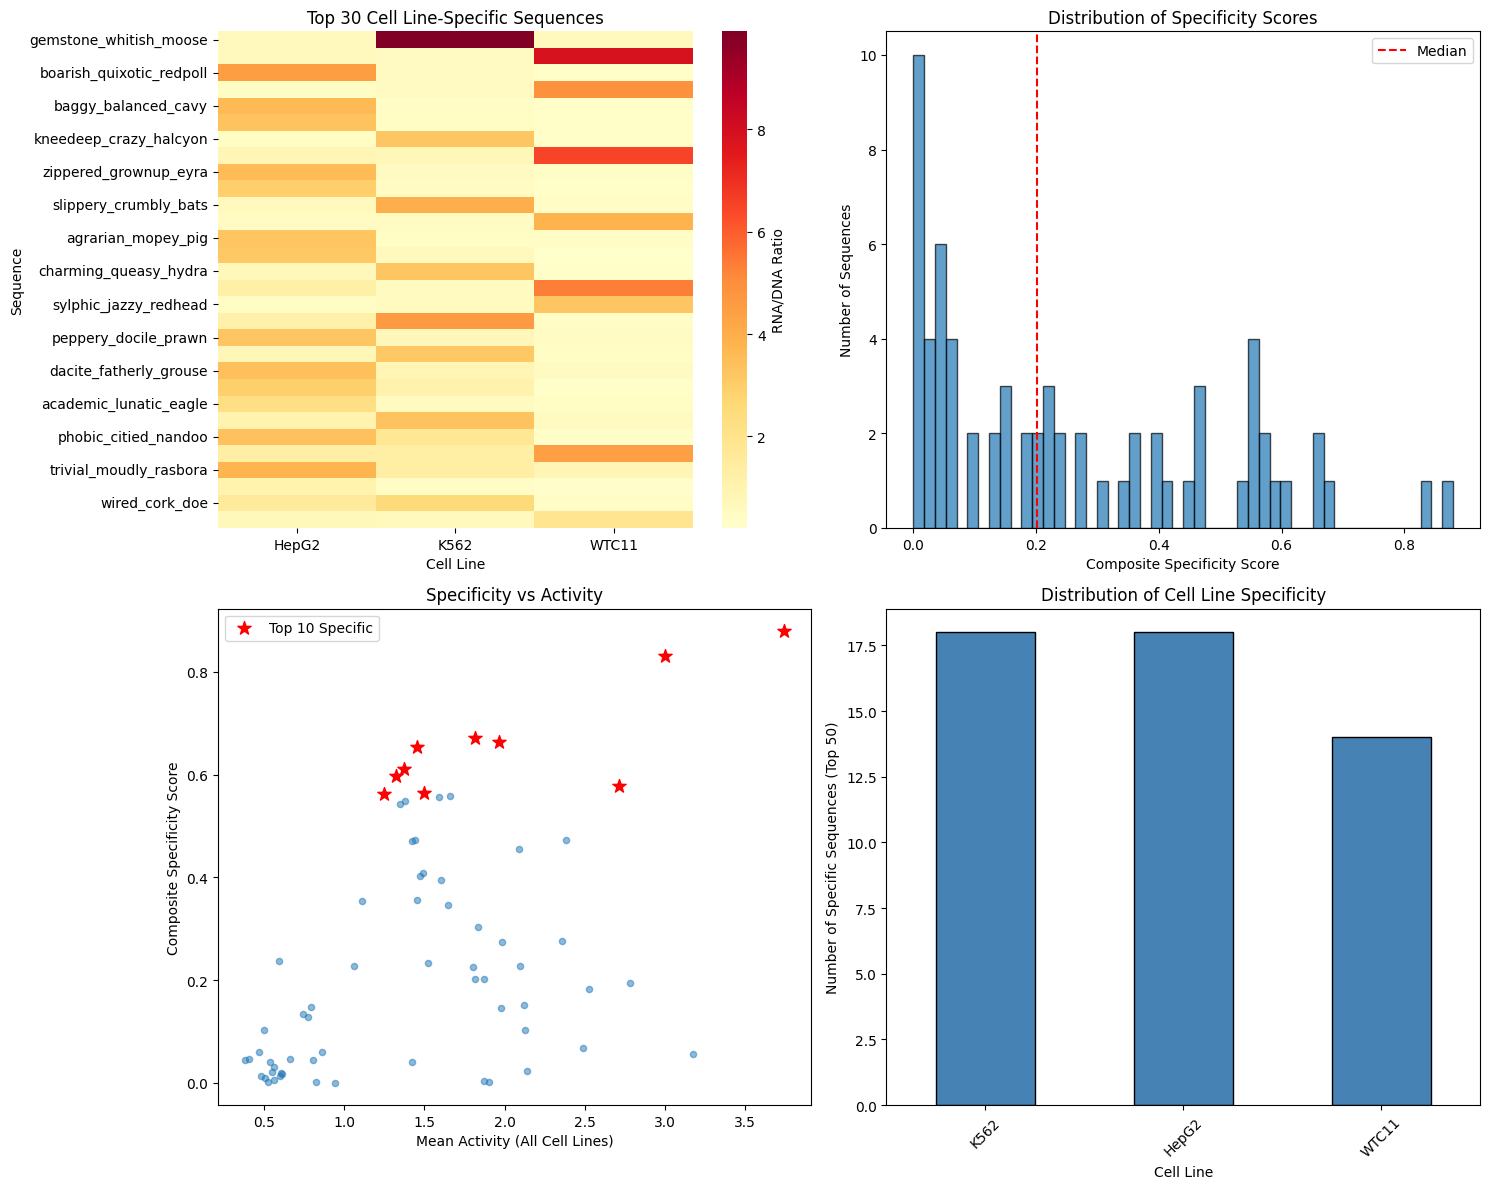

In [103]:

# Combine metrics into a composite score (weighted average)
# Normalize each score to 0-1 range
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

specificity_results['cv_specificity_norm'] = scaler.fit_transform(specificity_results[['cv_specificity']])
specificity_results['fc_specificity_norm'] = scaler.fit_transform(specificity_results[['fc_specificity']])
specificity_results['entropy_specificity_norm'] = specificity_results['entropy_specificity']  # Already 0-1

# Composite score (you can adjust weights as needed)
specificity_results['composite_specificity_score'] = (
    0.3 * specificity_results['cv_specificity_norm'] +
    0.4 * specificity_results['fc_specificity_norm'] +
    0.3 * specificity_results['entropy_specificity_norm']
)

# Sort by composite specificity score
specificity_results_sorted = specificity_results.sort_values('composite_specificity_score', ascending=False)

print("\n" + "="*80)
print("TOP 20 MOST CELL LINE-SPECIFIC SEQUENCES")
print("="*80)
print(specificity_results_sorted.head(20))

# Save results
specificity_results_sorted.to_csv('cell_line_specificity_results.csv')
print("\nResults saved to 'cell_line_specificity_results.csv'")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Heatmap of top specific sequences
top_n = min(30, len(specificity_results_sorted))
top_sequences = specificity_results_sorted.head(top_n).index
heatmap_data = activity_matrix.loc[top_sequences]

sns.heatmap(heatmap_data, ax=axes[0, 0], cmap='YlOrRd', cbar_kws={'label': 'RNA/DNA Ratio'})
axes[0, 0].set_title(f'Top {top_n} Cell Line-Specific Sequences')
axes[0, 0].set_xlabel('Cell Line')
axes[0, 0].set_ylabel('Sequence')

# 2. Distribution of specificity scores
axes[0, 1].hist(specificity_results['composite_specificity_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Composite Specificity Score')
axes[0, 1].set_ylabel('Number of Sequences')
axes[0, 1].set_title('Distribution of Specificity Scores')
axes[0, 1].axvline(specificity_results['composite_specificity_score'].median(), 
                    color='red', linestyle='--', label='Median')
axes[0, 1].legend()

# 3. Scatter plot: Specificity vs Mean Activity
axes[1, 0].scatter(specificity_results['mean_activity_all_cells'], 
                   specificity_results['composite_specificity_score'],
                   alpha=0.5, s=20)
axes[1, 0].set_xlabel('Mean Activity (All Cell Lines)')
axes[1, 0].set_ylabel('Composite Specificity Score')
axes[1, 0].set_title('Specificity vs Activity')

# Highlight top specific sequences
top_10 = specificity_results_sorted.head(10)
axes[1, 0].scatter(top_10['mean_activity_all_cells'], 
                   top_10['composite_specificity_score'],
                   color='red', s=100, marker='*', 
                   label='Top 10 Specific', zorder=5)
axes[1, 0].legend()

# 4. Bar plot: Count of specific sequences per cell line
cell_line_counts = specificity_results_sorted.head(50)['most_active_cell_line'].value_counts()
cell_line_counts.plot(kind='bar', ax=axes[1, 1], color='steelblue', edgecolor='black')
axes[1, 1].set_xlabel('Cell Line')
axes[1, 1].set_ylabel('Number of Specific Sequences (Top 50)')
axes[1, 1].set_title('Distribution of Cell Line Specificity')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('cell_line_specificity_analysis.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved to 'cell_line_specificity_analysis.png'")
plt.show()


In [104]:

# Create detailed report for top sequences
print("\n" + "="*80)
print("DETAILED REPORT: TOP 10 MOST SPECIFIC SEQUENCES")
print("="*80)

for i, (seq_name, row) in enumerate(specificity_results_sorted.head(10).iterrows(), 1):
    print(f"\n{i}. Sequence: {seq_name}")
    print(f"   Most active in: {row['most_active_cell_line']}")
    print(f"   Max activity: {row['max_activity']:.3f}")
    print(f"   Fold-change specificity: {row['fc_specificity']:.2f}x")
    print(f"   Composite specificity score: {row['composite_specificity_score']:.3f}")
    print(f"   Activity across cell lines:")
    for cell_line in activity_matrix.columns:
        val = activity_matrix.loc[seq_name, cell_line]
        marker = " *** " if cell_line == row['most_active_cell_line'] else "     "
        print(f"   {marker}{cell_line}: {val:.3f}")

print("\n" + "="*80)
print("Analysis complete!")


DETAILED REPORT: TOP 10 MOST SPECIFIC SEQUENCES

1. Sequence: gemstone_whitish_moose
   Most active in: K562
   Max activity: 9.918
   Fold-change specificity: 15.10x
   Composite specificity score: 0.879
   Activity across cell lines:
        HepG2: 0.662
    *** K562: 9.918
        WTC11: 0.652

2. Sequence: mucky_abasic_redhead
   Most active in: WTC11
   Max activity: 7.858
   Fold-change specificity: 13.85x
   Composite specificity score: 0.832
   Activity across cell lines:
        HepG2: 0.603
        K562: 0.531
    *** WTC11: 7.858

3. Sequence: boarish_quixotic_redpoll
   Most active in: HepG2
   Max activity: 4.533
   Fold-change specificity: 9.98x
   Composite specificity score: 0.671
   Activity across cell lines:
    *** HepG2: 4.533
        K562: 0.548
        WTC11: 0.361

4. Sequence: trusting_lazuline_mammal
   Most active in: WTC11
   Max activity: 4.892
   Fold-change specificity: 9.84x
   Composite specificity score: 0.664
   Activity across cell lines:
        He

In [105]:
specificity_results_sorted


,cv_specificity,fc_specificity,most_active_cell_line,max_activity,entropy_specificity,mean_activity_all_cells,cv_specificity_norm,fc_specificity_norm,entropy_specificity_norm,composite_specificity_score
sequence_name,,,,,,,,,,
gemstone_whitish_moose,1.428195,15.100665,K562,9.918152,0.597787,3.743919,1.000000,1.000000,0.597787,0.879336
mucky_abasic_redhead,1.404326,13.852781,WTC11,7.858188,0.575629,2.997572,0.982355,0.910952,0.575629,0.831776
boarish_quixotic_redpoll,1.299167,9.975366,HepG2,4.533271,0.487238,1.814055,0.904614,0.634264,0.487238,0.671261
trusting_lazuline_mammal,1.293363,9.843670,WTC11,4.892289,0.480257,1.962095,0.900323,0.624867,0.480257,0.664121
baggy_balanced_cavy,1.284233,9.587848,HepG2,3.610862,0.474216,1.454693,0.893573,0.606612,0.474216,0.652981
...,...,...,...,...,...,...,...,...,...,...
skilled_freaky_sunbear,0.082947,1.146318,K562,2.043762,0.002065,1.869849,0.005500,0.004233,0.002065,0.003963
acrylic_native_minnow,0.075813,1.127813,WTC11,0.891249,0.001734,0.823914,0.000226,0.002913,0.001734,0.001753
carroty_purply_fox,0.078279,1.104289,K562,2.027602,0.001878,1.899944,0.002049,0.001234,0.001878,0.001672


Text(0.5, 1.0, 'Wait... look at the spread! (gemstone_whitish_moose)')

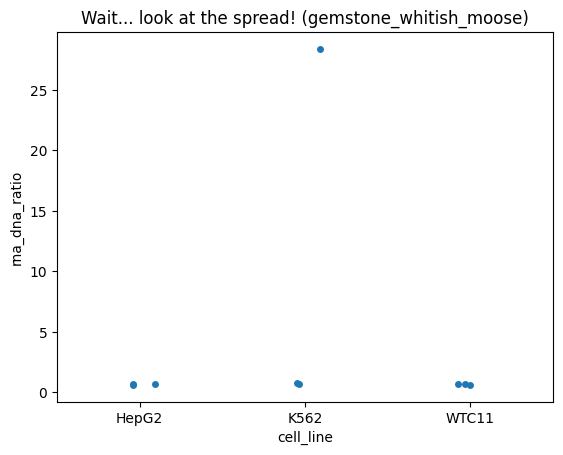

In [106]:
# Check the actual replicate values for top "specific" sequence
top_seq = specificity_results_sorted.index[0]

replicate_data = mpra_df[mpra_df["sequence_name"] == top_seq]

# Plot replicates
sns.stripplot(data=replicate_data, x="cell_line", y="rna_dna_ratio")
plt.title(f"Wait... look at the spread! ({top_seq})")

In [107]:
specificity_results_sorted

,cv_specificity,fc_specificity,most_active_cell_line,max_activity,entropy_specificity,mean_activity_all_cells,cv_specificity_norm,fc_specificity_norm,entropy_specificity_norm,composite_specificity_score
sequence_name,,,,,,,,,,
gemstone_whitish_moose,1.428195,15.100665,K562,9.918152,0.597787,3.743919,1.000000,1.000000,0.597787,0.879336
mucky_abasic_redhead,1.404326,13.852781,WTC11,7.858188,0.575629,2.997572,0.982355,0.910952,0.575629,0.831776
boarish_quixotic_redpoll,1.299167,9.975366,HepG2,4.533271,0.487238,1.814055,0.904614,0.634264,0.487238,0.671261
trusting_lazuline_mammal,1.293363,9.843670,WTC11,4.892289,0.480257,1.962095,0.900323,0.624867,0.480257,0.664121
baggy_balanced_cavy,1.284233,9.587848,HepG2,3.610862,0.474216,1.454693,0.893573,0.606612,0.474216,0.652981
...,...,...,...,...,...,...,...,...,...,...
skilled_freaky_sunbear,0.082947,1.146318,K562,2.043762,0.002065,1.869849,0.005500,0.004233,0.002065,0.003963
acrylic_native_minnow,0.075813,1.127813,WTC11,0.891249,0.001734,0.823914,0.000226,0.002913,0.001734,0.001753
carroty_purply_fox,0.078279,1.104289,K562,2.027602,0.001878,1.899944,0.002049,0.001234,0.001878,0.001672


Text(0.5, 1.0, 'Wait... what is this negative number doing here?! (wired_cork_doe)')

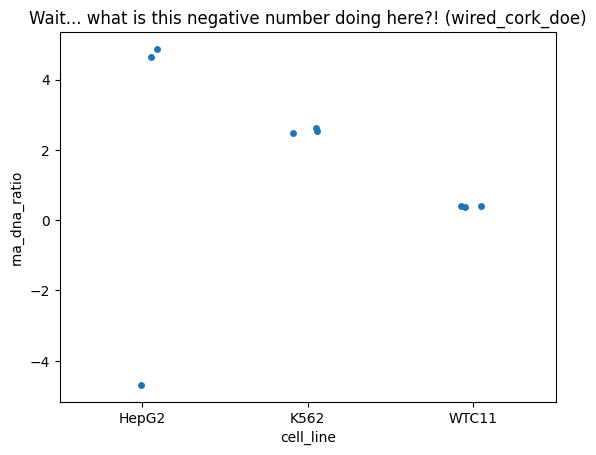

In [108]:
neg_seq = "wired_cork_doe"
replicate_data = mpra_df[mpra_df["sequence_name"] == neg_seq]

# Plot replicates
sns.stripplot(data=replicate_data, x="cell_line", y="rna_dna_ratio")
plt.title(f"Wait... what is this negative number doing here?! ({neg_seq})")
